# Ice Sheet Experiment

In [1]:
import sys
sys.path.append("../")
from mfmc import *

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(5)  #for reproducibility

### Load and preprocess data, select models

In [2]:
A1 = np.loadtxt('data/data.p000')
run_time = A1[:,1]
w = np.stack( [np.mean(run_time[200:]), np.mean(run_time[100:200]), np.mean(run_time[:100])] ) 

# print(np.sqrt(np.var(run_time[200:])), np.var(run_time[100:200]),np.var(run_time[:100]), '\n', w)

A1 = np.loadtxt('data/data.p003')
A3 = np.loadtxt('data/data.p002')

# Organizing the data
kinE = np.zeros((8500,3))
kinE[:4500,2] = A1[:4500,0]
kinE[4500:,2] = A3[:,0]
kinE[:1200,1] = A1[4500:5700,0]
kinE[:600,0] = A1[5700:,0]

N = 100  #number of samples for corr/var estimation
nrRuns = 1
X = np.zeros((N,3,nrRuns))
for j in range(nrRuns):
    print(f'run {j+1} of {nrRuns}')
#     perm = np.random.permutation(100)
    perm = rng.permutation(range(100))
    X[:,:,j] = kinE[perm[:N],:]
X = np.mean(X, axis=2)

print(w)
print(np.corrcoef(X.T))

# generate optimal ordering of models
[bestSet, bestV, vMC] = optimalOrderCorr(X, w, w[0]*2**6, 1)
w = w[bestSet]
X = X[:, bestSet]
print(f'selected models {bestSet}')

run 1 of 1
[285.47829519  23.0522937    2.69001624]
[[1.         0.99999796 0.99996691]
 [0.99999796 1.         0.99998127]
 [0.99996691 0.99998127 1.        ]]
[0] has variance 1322661.1988265873
[0 1] has variance 108844.26110720634
[0 2] has variance 14638.929819535464
[0 1 2] has variance 13579.71882083267
selected models [0 1 2]


In [3]:
nrRuns = 250  #average of nrRuns runs
pList = w[0]*np.array([2**k for k in range(1,7)])

# Modified MFMC

# estimate mean of output
yMean = np.zeros((len(pList), nrRuns))
costs = np.zeros(len(pList))
for run in range(nrRuns):
#     print(f'run {run+1} of {nrRuns}')
    for (j,p) in enumerate(pList):  #compute estimate for different budgets
        # compute optimal number of model evals/coefficients
        Mlevel, coeff, v = optiMlevelCorr(X, w, p, 1)
        if run==0: print(f'Number of model evals is {Mlevel}')

        # FO model
        perm = np.random.permutation(600)
        y = kinE[perm[:Mlevel[0]], 0]
        yMeanCur = coeff[0] * np.mean(y)
        costs[j] = Mlevel[0] * w[0]
    
        # iterate over all other models
        idx = np.array([0,600,1200,8500])
        for i in range(1, len(w)):
            permNew = np.zeros(idx[i+1])
            permNew[:idx[i]] = perm
            pRest = idx[i] + rng.permutation(range(idx[i+1] - idx[i]))
            permNew[idx[i]:idx[i+1]] = pRest
            permNew = permNew.astype(int)
            y = kinE[permNew[:Mlevel[i]], i]
            yMeanCur = yMeanCur + coeff[i] * (np.mean(y) - np.mean(y[:Mlevel[i-1]]))
            costs[j] = costs[j] + Mlevel[i] * w[i]
            perm = permNew

        yMean[j, run] = yMeanCur
        
    
# Simple MC
        
yMeanFOM = np.zeros((len(pList), nrRuns))
costsFOM = np.zeros(len(pList))
for run in range(nrRuns):
    perm = rng.permutation(rng.permutation(range(600)))  #trick to get new permutation with same seed
    for (j,p) in enumerate(pList):
        M = np.ceil(p / w[0]).astype(int)  #number of samples
        y = kinE[perm[:M], 0]
        yMeanFOM[j, run] = np.mean(y)
        costsFOM[j] = M * w[0]

Number of model evals is [ 1  1 97]
Number of model evals is [  1   1 309]
Number of model evals is [  1   1 726]
Number of model evals is [   1    4 1555]
Number of model evals is [   1    8 3215]
Number of model evals is [   1   17 6506]


### Compute metrics for evaluation and plot results

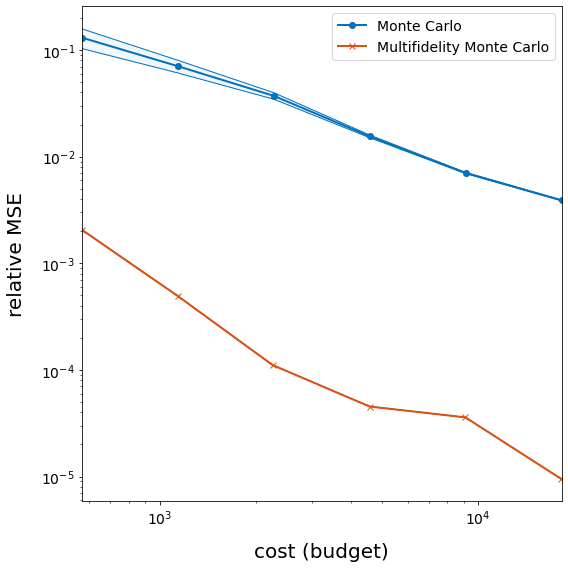

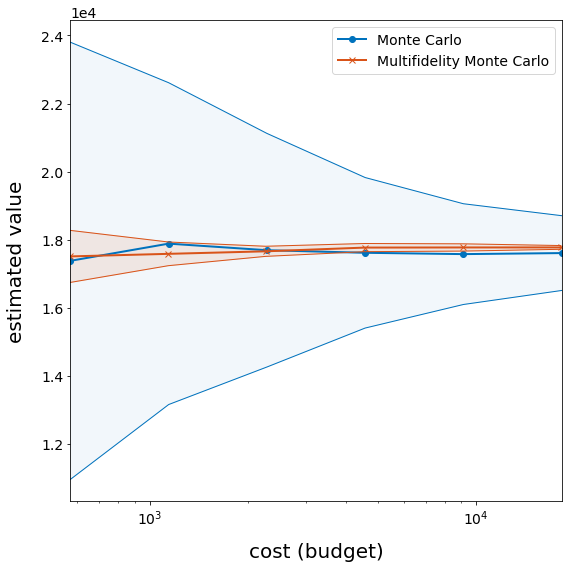

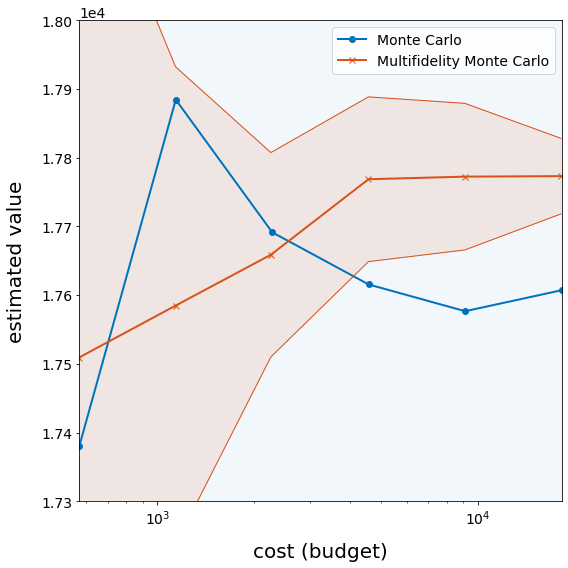

In [4]:
myMeanFOM = np.mean(yMeanFOM, axis=1)
myMean = np.mean(yMean, axis=1)

yMeanStdFOM = np.std(yMeanFOM, axis=1, ddof=1)
yMeanStd = np.std(yMean, axis=1, ddof=1)


# estimate reference mean (USING MFMC!)
yMeanRef = np.mean(yMean[-1])
# yMeanRef = mean(yMeanFOM(end,:));

# estimate MSE
mseMFMC = np.zeros(len(pList))
mseMC = np.zeros(len(pList))
abseMFMC = np.zeros(len(pList))
abseMC = np.zeros(len(pList))
for j in range(len(pList)):
    mseMFMC[j] = np.mean((yMeanRef - yMean[j])**2)
    abseMFMC[j] = np.mean(np.abs(yMeanRef - yMean[j]))
    mseMC[j] = np.mean((yMeanRef - yMeanFOM[j])**2)
    abseMC[j] = np.mean(np.abs(yMeanRef - yMeanFOM[j]))

mseMC = np.mean((yMeanRef - yMeanFOM)**2, axis=1)
mseMFMC = np.mean((yMeanRef - yMean)**2, axis=1)

varmseMC = np.var((yMeanRef - yMeanFOM)**2 / yMeanRef**2, axis=1)
varmseMFMC = np.var((yMeanRef - yMean)**2 / yMeanRef**2, axis=1)

relmseMC = mseMC / yMeanRef**2
relmseMFMC = mseMFMC / yMeanRef**2

# Plotting
c1 = [0, 0.4470, 0.7410];
c2 = [0.8500, 0.3250, 0.0980];
c4 = [0.4940, 0.1840, 0.5560];
c3 = [0.4660, 0.6740, 0.1880];

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('cost (budget)', labelpad=15)
ax.set_ylabel('relative MSE', labelpad=15)
ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)
ax.set_xlim([pList[0],pList[-1]])
ax.plot(costsFOM, relmseMC, '-o', color=c1, linewidth=2, label='Monte Carlo')
ax.plot(costs, relmseMFMC, '-x', color=c2, linewidth=2, label='Multifidelity Monte Carlo')
x=costsFOM
curve1 = relmseMC + varmseMC
curve2 = relmseMC - varmseMC
ax.plot(x, curve1, color=c1, linewidth=1)
ax.plot(x, curve2, color=c1, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c1, alpha=0.05)
x=costs
curve1 = relmseMFMC + varmseMFMC
curve2 = relmseMFMC - varmseMFMC
ax.plot(x, curve1, color=c2, linewidth=1)
ax.plot(x, curve2, color=c2, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c2, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size': 14})
plt.tight_layout()
# plt.savefig('ice_mses.png', transparent=True)
plt.show()

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('cost (budget)', labelpad=15)
ax.set_ylabel('estimated value', labelpad=15)
ax.set_xscale('log', base=10)
ax.set_xlim([pList[0], pList[-1]])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(14)
ax.plot(costsFOM, myMeanFOM, '-o', color=c1, linewidth=2, label='Monte Carlo')
ax.plot(costs, myMean, '-x', color=c2, linewidth=2, label='Multifidelity Monte Carlo')
x=costsFOM
curve1 = myMeanFOM + yMeanStdFOM
curve2 = myMeanFOM - yMeanStdFOM
ax.plot(x, curve1, color=c1, linewidth=1)
ax.plot(x, curve2, color=c1, linewidth=1)
x2 = np.concatenate((x, x[::-1]), axis=0)
inBetween = np.concatenate((curve1, curve2[::-1]), axis=0)
ax.fill(x2, inBetween, color=c1, alpha=0.05)
x=costs
curve1 = myMean + yMeanStd
curve2 = myMean - yMeanStd
ax.plot(x, curve1, color=c2, linewidth=1)
ax.plot(x, curve2, color=c2, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c2, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size': 14})
plt.tight_layout()
# plt.savefig('ice_values.png', transparent=True)
plt.show()

fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('cost (budget)', labelpad=15)
ax.set_ylabel('estimated value', labelpad=15)
ax.set_xscale('log', base=10)
ax.set_xlim([pList[0], pList[-1]])
ax.set_ylim([17300, 18000])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.yaxis.get_offset_text().set_fontsize(14)
ax.plot(costsFOM, myMeanFOM, '-o', color=c1, linewidth=2, label='Monte Carlo')
ax.plot(costs, myMean, '-x', color=c2, linewidth=2, label='Multifidelity Monte Carlo')
x=costsFOM
curve1 = myMeanFOM + yMeanStdFOM
curve2 = myMeanFOM - yMeanStdFOM
ax.plot(x, curve1, color=c1, linewidth=1)
ax.plot(x, curve2, color=c1, linewidth=1)
x2 = np.concatenate((x, x[::-1]), axis=0)
inBetween = np.concatenate((curve1, curve2[::-1]), axis=0)
ax.fill(x2, inBetween, color=c1, alpha=0.05)
x=costs
curve1 = myMean + yMeanStd
curve2 = myMean - yMeanStd
ax.plot(x, curve1, color=c2, linewidth=1)
ax.plot(x, curve2, color=c2, linewidth=1)
x2 = np.concatenate([x, x[::-1]], axis=0)
inBetween = np.concatenate([curve1, curve2[::-1]], axis=0)
ax.fill(x2, inBetween, color=c2, alpha=0.1)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size': 14})
plt.tight_layout()
# plt.savefig('ice_values_close.png', transparent=True)
plt.show()